In [1]:
import numpy as np
import pandas as pd
import glob
import h5py 
import random
import matplotlib.pyplot as plt
import pickle as pkl
import os

In [2]:
filename = "./routing_outputs/q_lstm_good.h5"
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['flow']>


In [3]:
mydir = "./catchment_outputs/"
file_list = glob.glob(mydir + "/*.csv") # Include slash or it will search in the wrong directory!!

In [4]:
n_catchments = len(file_list)

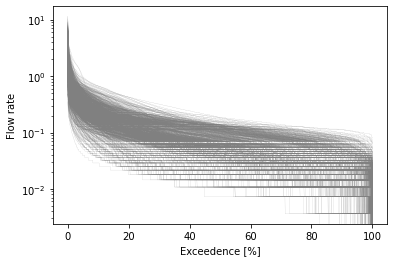

In [5]:
ngen_exceedences = {}
ngen_sorted_flows = {}
for cat_out_indx in [random.randrange(n_catchments) for i in range(1000)]:
    catchment_id = file_list[cat_out_indx].split("-")[-1].split(".")[0]
    with open(file_list[cat_out_indx], "r") as f:
        data = pd.read_csv(f)
    flowz = data["land_surface_water__runoff_depth"]*3600
    sort = np.sort(flowz)[::-1]
    exceedence = np.arange(1.,len(sort)+1) / len(sort)
    exceedence = exceedence*100
    ngen_exceedences[catchment_id] = exceedence
    ngen_sorted_flows[catchment_id] = sort
    plt.plot(exceedence, sort, c='grey', lw=.1)
plt.xlabel("Exceedence [%]")
plt.ylabel("Flow rate")
plt.yscale("log")
plt.show()
plt.close()

In [6]:
n_flow_values = []
for i in list(ngen_exceedences.keys()):
    n_flow_values.append(ngen_exceedences[i].shape[0])
min_n_flow_values = np.min(np.array(n_flow_values))
max_n_flow_values = np.max(np.array(n_flow_values))
new_ngen_exceedences = {}
new_ngen_sorted_flows = {}
for i in list(ngen_exceedences.keys()):
    indexing_array = np.sort(np.random.randint(0,ngen_exceedences[i].shape[0], min_n_flow_values))
    new_ngen_exceedences[i] = ngen_exceedences[i][indexing_array]
    new_ngen_sorted_flows[i] = ngen_sorted_flows[i][indexing_array]

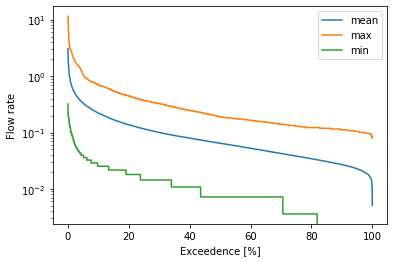

In [7]:
df_exc = pd.DataFrame(new_ngen_exceedences)
df_sort = pd.DataFrame(new_ngen_sorted_flows)

mean_ngen_sorted_flows = df_sort.mean(axis=1).values
max_ngen_sorted_flows = df_sort.max(axis=1).values
min_ngen_sorted_flows = df_sort.min(axis=1).values

mean_ngen_exceedence = df_exc.mean(axis=1).values
max_ngen_exceedence = df_exc.max(axis=1).values
min_ngen_exceedence = df_exc.min(axis=1).values

plt.plot(mean_ngen_exceedence, mean_ngen_sorted_flows, label="mean")
plt.plot(max_ngen_exceedence, max_ngen_sorted_flows, label="max")
plt.plot(min_ngen_exceedence, min_ngen_sorted_flows, label="min")
plt.xlabel("Exceedence [%]")
plt.ylabel("Flow rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

In [8]:
# Definitions
area_index='area_geospa_fabric'
sample_basin = '11532500'
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']
if True: # Open the attributes from the coding workshop. These are already set up to do regression
    openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)
# Get the hydrologic units for each basin.
data_dir = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_april2021/data/'
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [9]:
obs_flows_huc01 = {}
for i in attributes.index.values:
    if attributes.loc[i, 'basin_hydro_unit'] != '01':
        continue
    print(i)
    fname = f"/home/NearingLab/data/camels_data_hourly/usgs_streamflow/{str(i).zfill(8)}-usgs-hourly.csv"
    if not os.path.exists(fname):
        print("file does not exist, moving on")
        continue
    with open(fname, "r") as f:
        df = pd.read_csv(f)
    df = df.loc[pd.to_datetime(df['date']) > pd.to_datetime("2008-10-01 00:00:00")]
    df = df.loc[pd.to_datetime(df['date']) < pd.to_datetime("2010-10-01 00:00:00")]    
    obs_flows_huc01[i] = df['QObs(mm/h)'].values

1013500
file does not exist, moving on
1022500
1030500
file does not exist, moving on
1031500
1047000
1052500
1054200
1055000
1057000
1073000
1078000
1118300
file does not exist, moving on
1121000
file does not exist, moving on
1123000
1134500
1137500
1139000
1139800
1142500
1144000
1162500
1169000
1170100
1181000
1187300
1195100


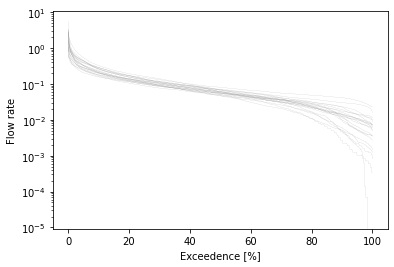

In [10]:
camels_exceedences = {}
camels_sorted_flows = {}
for cam_id_huc01 in obs_flows_huc01.keys():
    
    flowz = obs_flows_huc01[cam_id_huc01]
    flowz = flowz[~np.isnan(flowz)]
    sort = np.sort(flowz)[::-1]
    exceedence = np.arange(1.,len(sort)+1) / len(sort)
    exceedence = exceedence*100
    
    camels_exceedences[cam_id_huc01] = exceedence
    camels_sorted_flows[cam_id_huc01] = sort
    
    plt.plot(exceedence, sort, c='grey', lw=.1)
plt.xlabel("Exceedence [%]")
plt.ylabel("Flow rate")
plt.yscale("log")
plt.show()
plt.close()

In [11]:
n_flow_values = []
for i in list(camels_exceedences.keys()):
    n_flow_values.append(camels_exceedences[i].shape[0])
min_n_flow_values = np.min(np.array(n_flow_values))
max_n_flow_values = np.max(np.array(n_flow_values))
new_camels_exceedences = {}
new_camels_sorted_flows = {}
for i in list(camels_exceedences.keys()):
    indexing_array = np.sort(np.random.randint(0,camels_exceedences[i].shape[0], min_n_flow_values))
    new_camels_exceedences[i] = camels_exceedences[i][indexing_array]
    new_camels_sorted_flows[i] = camels_sorted_flows[i][indexing_array]

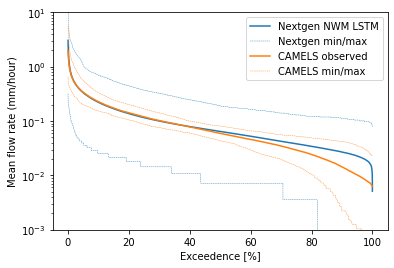

In [29]:
df_exc = pd.DataFrame(new_camels_exceedences)
df_sort = pd.DataFrame(new_camels_sorted_flows)

mean_camels_sorted_flows = df_sort.mean(axis=1).values
max_camels_sorted_flows = df_sort.max(axis=1).values
min_camels_sorted_flows = df_sort.min(axis=1).values

mean_camels_exceedence = df_exc.mean(axis=1).values
max_camels_exceedence = df_exc.max(axis=1).values
min_camels_exceedence = df_exc.min(axis=1).values
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']
plt.plot(mean_ngen_exceedence, mean_ngen_sorted_flows, label="Nextgen NWM LSTM", c=colz[0])
plt.plot(max_ngen_exceedence, max_ngen_sorted_flows, '--', c=colz[0], label="Nextgen min/max", lw=.4)
plt.plot(min_ngen_exceedence, min_ngen_sorted_flows, '--', c=colz[0], lw=.4)
plt.plot(mean_camels_exceedence, mean_camels_sorted_flows, label="CAMELS observed", c=colz[1])
plt.plot(max_camels_exceedence, max_camels_sorted_flows, '--', c=colz[1], lw=.4, label="CAMELS min/max")
plt.plot(min_camels_exceedence, min_camels_sorted_flows, '--', c=colz[1], lw=.4)
plt.xlabel("Exceedence [%]")
plt.ylabel("Mean flow rate (mm/hour)")
plt.yscale("log")
plt.ylim([0.001,10])
plt.legend()
plt.savefig("flow_duration_curve.pdf")
plt.savefig("flow_duration_curve.png")
plt.show()
plt.close()